<a href="https://colab.research.google.com/github/sobhanshukueian/Reinforcement-Learning-Playground/blob/main/Policy_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Policy Gradient

implementation using pyotrch

author : Sobhan Shukueian

---
### TODO

- [x] Gym episodes
- [x] Model
- [x] policy and action functions
- [x] Train loop
- [x] Visualize results

# Dependencies


In [ ]:
!pip3 install gymnasium[classic_control]

In [ ]:
import os
import numpy as np
import gymnasium as gym
import random
import argparse
import glob
import matplotlib.pyplot as plt
from copy import deepcopy


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Gym


In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
env.action_space

Discrete(2)

In [ ]:
env.action_space.seed(3)

[3]

In [ ]:
env.reset(seed=3)
env.step(0)

(array([-0.04196146, -0.22185972,  0.03029177,  0.3102504 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [ ]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        # env.render()
        action = random.choice([0,1])
        observation, reward, done, truncated, info = env.step(action)
        # print(observation)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

env.close()

Episode:1 Score:17.0
Episode:2 Score:14.0
Episode:3 Score:12.0
Episode:4 Score:19.0
Episode:5 Score:23.0
Episode:6 Score:54.0
Episode:7 Score:12.0
Episode:8 Score:16.0
Episode:9 Score:53.0
Episode:10 Score:11.0


# Model


In [ ]:
class PolicyNet(nn.Module):

    def __init__(self, n_observations=4, n_actions=2):
        super(PolicyNet, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Train Helpers


In [ ]:
# @title Arguments
parser = argparse.ArgumentParser(description='Policy Gradient')

parser.add_argument('--epochs', default=300, type=int, metavar='N', help='Number of epochs for training agent.')
parser.add_argument('--episodes', default=100, type=int, metavar='N', help='Number of episodes for training agent.')
parser.add_argument('--lr', '--learning-rate', default=1e-2, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', default=0.0001, type=float, help='Weight decay for training optimizer')
parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
parser.add_argument('--model-name', default="policy_net", type=str, help='Model name for saving model.')


# utils
parser.add_argument('--resume', default="", type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--save-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')

# args = parser.parse_args()  # running in command line
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
if args.save_dir == '':
    args.save_dir = "./PolicyNet"

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(args)

Namespace(epochs=300, episodes=100, lr=0.01, wd=0.0001, seed=3, model_name='policy_net', resume='', save_dir='./PolicyNet', device=device(type='cpu'))


In [ ]:
# @title Trianing Helpers
def reproducibility(SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)
    env.action_space.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

def save(model, epoch, optimizer, model_name=args.model_name):
    filename = os.path.join(args.results_dir, f'{model_name}.pt')
    # save ckpt
    ckpt = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            }
    torch.save(ckpt, filename)

def load(model, optimizer, model_name=args.model_name):
    # Find the most recent saved checkpoint in search_dir
    checkpoint_list = glob.glob(f'{args.resume}/**/{model_name}*.pt', recursive=True)
    checkpoint_path = max(checkpoint_list, key=os.path.getctime) if checkpoint_list else ''
    assert os.path.isfile(checkpoint_path), f'the checkpoint path is not exist: {checkpoint_path}'
    print(f'Resume training from the checkpoint file :{checkpoint_path}')
    #load checkpoint
    ckpt = torch.load(checkpoint_path)

    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    start_epoch = ckpt['epoch'] + 1

    return model, optimizer, start_epoch

def prepare_save_dir():
    temm=0
    tmp_save_dir = os.path.join(args.save_dir, "run")
    while os.path.exists(tmp_save_dir):
        tmp_save_dir = os.path.join(args.save_dir, "run")
        temm+=1
        tmp_save_dir += (str(temm))
    args.results_dir = tmp_save_dir
    os.makedirs(args.results_dir)

    # Save Arguments in results dir
    with open(os.path.join(args.results_dir, "args.txt"), "w") as text_file:
        for key, value in vars(args).items():
            text_file.write(f"{key}: {value}\n")

    print("Save Project in {} directory.".format(args.results_dir))

# Train Loop


In [ ]:
reproducibility(args.seed)

start_epoch = 0
policy_net = PolicyNet()
optimizer = optim.Adam(policy_net.parameters(), lr=args.lr, weight_decay=args.wd)

if args.resume:
    policy_net, optimizer, start_epoch = load(policy_net, optimizer)

losses = []
scores = []

print("Start Training")
prepare_save_dir()

print(('%20s' * 4) % ('Phase' ,'Epoch', 'Loss', 'Score'))
# Start Training
for epoch in range(start_epoch, args.epochs):
    policy_net.train()
    # Define Array for logarithm of probabilities and rewards to calculate loss
    log_probabilities, rewards = [], []
    # Define success time variable for calculating the duration of successful rotation
    success_time = 0

    # Each epoch (episodes) will run
    for episode in range(args.episodes):
        observation = env.reset(seed=args.seed)[0]

        done=False
        score = 0
        success_time = 0

        # Run each episode
        while done==False:
            success_time += 1

            # observation to tensor
            observation = torch.tensor(observation)

            # Get the action probabilities from policy net
            logits = policy_net(observation)

            # To (multinomial) distribution to sample action from this distribution
            policy = torch.distributions.categorical.Categorical(logits=logits)

            #sample action from distribution under policy
            action = policy.sample()

            # Take the sampled action in environment
            observation, reward, terminated, truncated, _ = env.step(int(action.item()))
            done = terminated or truncated

            score += reward

            # Calculate logarithm of the actions probability
            log_probability = policy.log_prob(action)
            log_probabilities.append(log_probability)

        rewards += [score for i in range(success_time)]


    # Calculate policy gradient loss
    loss = -(torch.stack(log_probabilities) * torch.as_tensor(rewards, dtype=torch.float32)).mean()

    losses.append(loss)
    scores.append(score)

    print('%20s' * 4  % ("Train", f'{epoch}/{args.epochs}', loss.item(), score))

    # Optimize model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%5 == 0:
        save(model=policy_net, epoch=epoch, optimizer=optimizer)

Start Training
Save Project in ./PolicyNet/run31 directory.
               Phase               Epoch                Loss               Score
               Train               0/300  20.615968704223633                16.0
               Train               1/300  21.461681365966797                27.0
               Train               2/300  39.748329162597656                52.0
               Train               3/300   37.91095733642578                39.0
               Train               4/300    37.1429328918457                43.0
               Train               5/300   51.55247497558594               101.0
               Train               6/300     51.352783203125                45.0
               Train               7/300   50.20244598388672                93.0
               Train               8/300   62.51276779174805                72.0
               Train               9/300   50.26545333862305               111.0
               Train              10/300   34.959

# Visualize results

In [ ]:
losses = [loss.cpu().detach().numpy() for loss in losses]

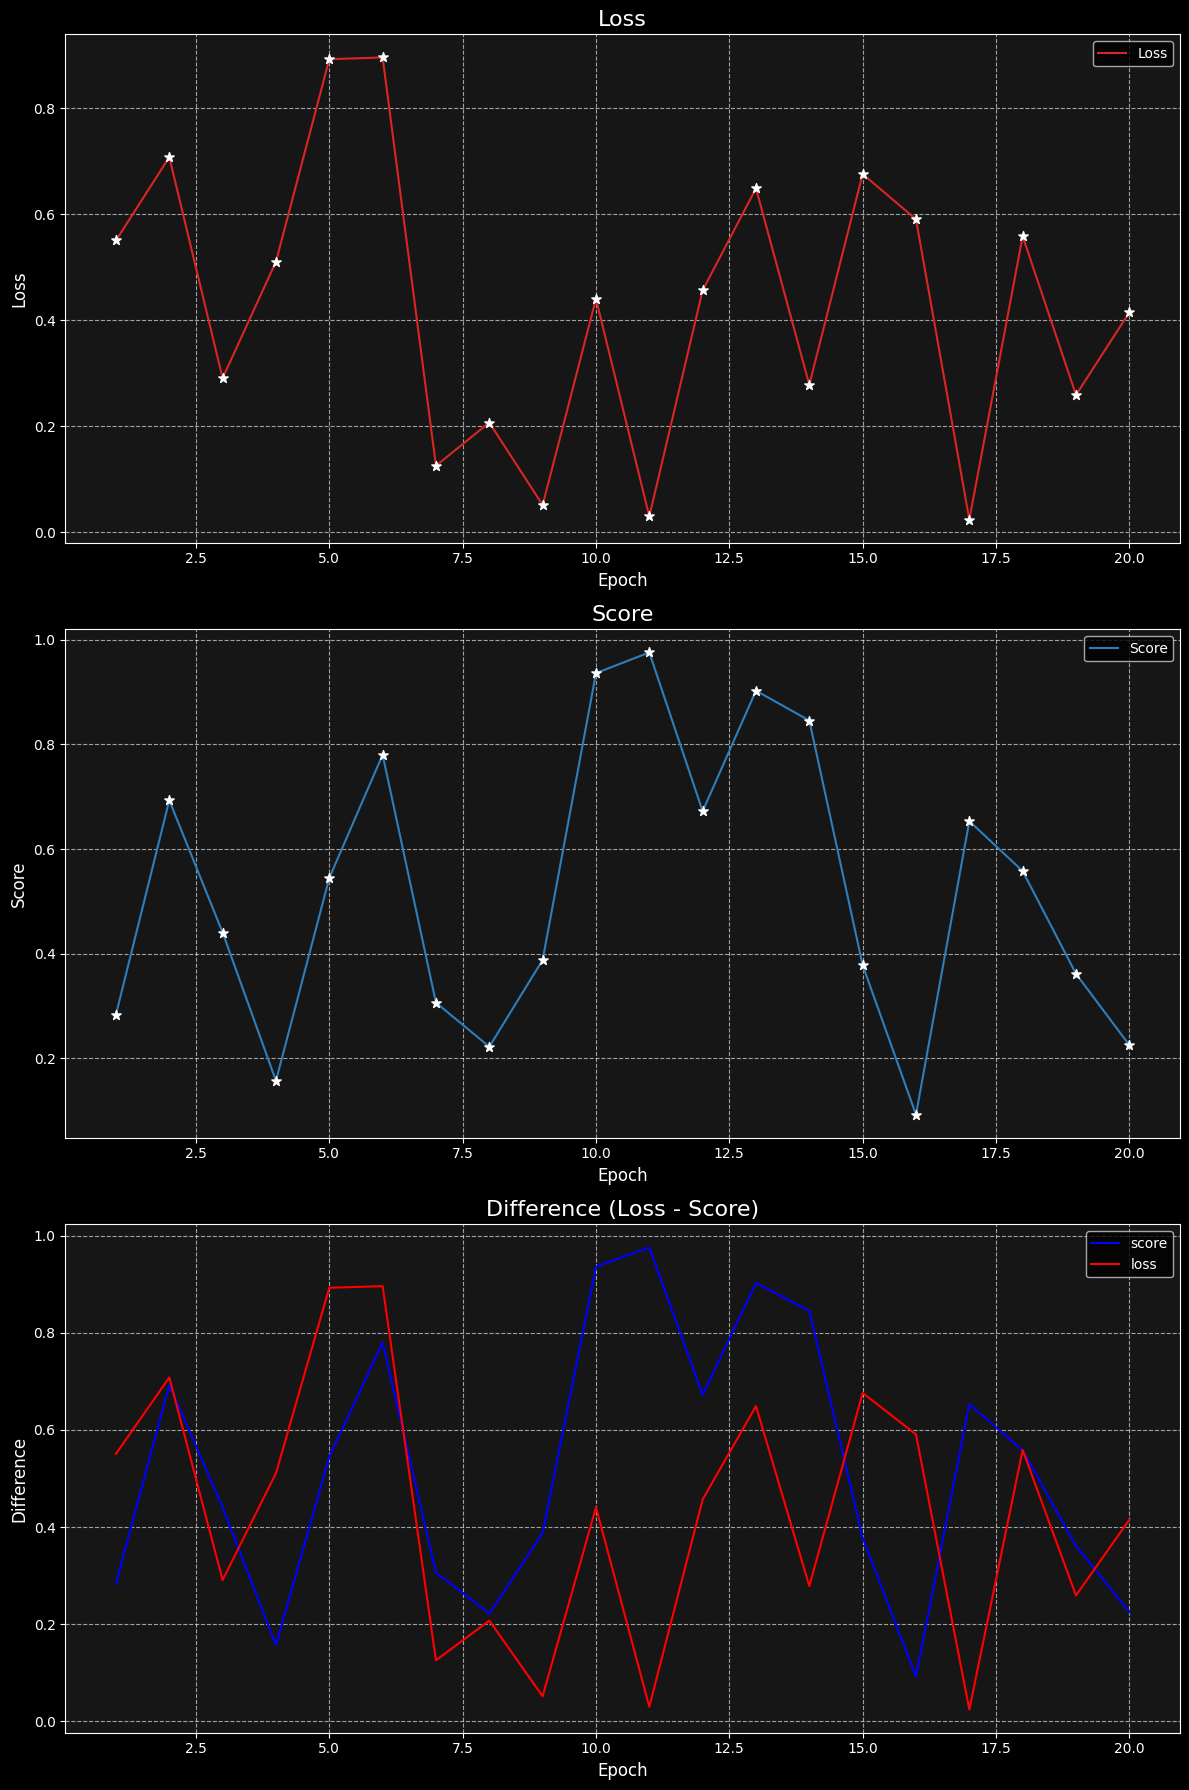

In [ ]:
def plot(loss, score):
    # Create a custom style for the plot
    plt.style.use('dark_background')

    # Create subplots with 2 rows and 1 column
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Set custom color maps
    cmap_loss = plt.get_cmap("Reds")
    cmap_score = plt.get_cmap("Blues")

    # Plot for loss
    epochs = range(1, len(loss) + 1)
    axs[0].plot(epochs, loss, label='Loss', linestyle='-', color=cmap_loss(0.7))
    axs[0].set_title('Loss', fontsize=16, color='white')
    axs[0].set_xlabel('Epoch', fontsize=12, color='white')
    axs[0].set_ylabel('Loss', fontsize=12, color='white')
    axs[0].legend()

    # Plot for score
    axs[1].plot(epochs, score, label='Score', linestyle='-', color=cmap_score(0.7))
    axs[1].set_title('Score', fontsize=16, color='white')
    axs[1].set_xlabel('Epoch', fontsize=12, color='white')
    axs[1].set_ylabel('Score', fontsize=12, color='white')
    axs[1].legend()

    # Customize tick colors
    axs[0].tick_params(axis='both', colors='white')
    axs[1].tick_params(axis='both', colors='white')

    # Add some fantasy elements (e.g., stars)
    axs[0].scatter(np.arange(1, len(loss) + 1), loss, c='white', marker='*', s=50, zorder=10)
    axs[1].scatter(np.arange(1, len(score) + 1), score, c='white', marker='*', s=50, zorder=10)

    # Add a background gradient
    axs[0].set_facecolor('#161616')
    axs[1].set_facecolor('#161616')

    # Add gridlines
    axs[0].grid(True, linestyle='--', alpha=0.6, color='white')
    axs[1].grid(True, linestyle='--', alpha=0.6, color='white')

    # Plot the difference
    axs[2].plot(epochs, score, label='score', linestyle='-', color='blue')
    axs[2].plot(epochs, loss, label='loss', linestyle='-', color='red')
    axs[2].set_title('Difference (Loss - Score)', fontsize=16, color='white')
    axs[2].set_xlabel('Epoch', fontsize=12, color='white')
    axs[2].set_ylabel('Difference', fontsize=12, color='white')
    axs[2].legend()

    # Customize tick colors for the difference plot
    axs[2].tick_params(axis='both', colors='white')

    # Add a background gradient for the difference plot
    axs[2].set_facecolor('#161616')

    # Add gridlines for the difference plot
    axs[2].grid(True, linestyle='--', alpha=0.6, color='white')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
plot(losses, scores)